In [2]:
# import packages
import ast
import gzip
import os
import gc
import re
import itertools
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from collections import Counter, defaultdict

2025-12-02 19:31:21.750518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# EDA

This section is dedicated to loading, preprocessing, and doing EDA on the steam_games and steam_reviews datasets. Data was first loaded in and then made into dataframes (df corresponds to the reviews dataset, and df_games corresponds to the games dataset). The data was also converted from .json.gz files into .csv files as those (from my experience at least) are easier to work with. Make sure to run everything in this notebook in order so that the imports load in a way that allows everything to work. Also make sure that either the steam_reviews, steam_games, australian_users_items, and australian_user_reviews json.gz files are located within the same location as this notebook or change the code so that it can reach those files from wherever they are stored.

In [3]:
#list to hold each review as a dictionary
rows = []

#open the gzip file and read line by line, handling any missing lines
with gzip.open("steam_reviews.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        else:
            obj = ast.literal_eval(line)   #converts Python dict to real dict
            rows.append(obj)

#convert list of dictionaries to pandas dataframe
df = pd.DataFrame(rows)

#display the first few rows of the dataframe
df.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [4]:
#list to hold each game and its details as a dictionary
rows_game = []

#open the gzip file and read line by line, handling any missing lines
with gzip.open("steam_games.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        else:
            obj = ast.literal_eval(line)   # converts Python dict to real dict
            rows_game.append(obj)

#convert list of dictionaries to pandas dataframe
df_games = pd.DataFrame(rows_game)

#display the first few rows of the dataframe
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [5]:
#same as above but for australian users and items
#list to hold each review as a dictionary
aus_item_rows = []

#open the gzip file and read line by line, handling any missing lines
with gzip.open("australian_users_items.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        else:
            obj = ast.literal_eval(line)   #converts Python dict to real dict
            aus_item_rows.append(obj)

#convert list of dictionaries to pandas dataframe
aus_item_df = pd.DataFrame(aus_item_rows)

#display the first few rows of the dataframe
aus_item_df.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [6]:
#same as above but for australian users and reviews
#list to hold each review as a dictionary
aus_review_rows = []

#open the gzip file and read line by line, handling any missing lines
with gzip.open("australian_user_reviews.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        else:
            obj = ast.literal_eval(line)   #converts Python dict to real dict
            aus_review_rows.append(obj)

#convert list of dictionaries to pandas dataframe
aus_review_df = pd.DataFrame(aus_review_rows)

#display the first few rows of the dataframe
aus_review_df.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [7]:
#there was one game that appeared twice, so we drop the duplicate
df_games = df_games.drop_duplicates(subset=['id'], keep='first')

#convert dataframes to csv files for easier handling
df.to_csv('steam_reviews.csv', index=False)
df_games.to_csv('steam_games.csv', index=False)
aus_item_df.to_csv('australian_user_items.csv', index=False)
aus_review_df.to_csv('australian_user_reviews.csv', index=False)

In [8]:
games_df = pd.read_csv('steam_games.csv')
reviews_df = pd.read_csv('steam_reviews.csv')
aus_item_df = pd.read_csv('australian_user_items.csv')
aus_review_df = pd.read_csv('australian_user_reviews.csv')

After datasets were loaded in and preprocessed, EDA was performed. First, steam_games and steam_reviews were looked at. Below code calcuates summary statistics of user playtime, along with analyzing the review lengths, avg games and reviews per user, and avaliablility of data in the datasets.

In [9]:
def analyze_features(reviews_df, games_df):
    """
    Analyze which features are most valuable for game recommendations
    """
    
    print("=== FEATURE ANALYSIS FOR RECOMMENDER SYSTEM ===")
    
    # merge datasets to get game information for each review
    merged_df = reviews_df.merge(games_df, left_on='product_id', right_on='id', how='left')
    
    # playtime (hours)
    print("\n1. PLAY TIME ANALYSIS:")
    print(f"Average playtime: {reviews_df['hours'].mean():.2f} hours")
    print(f"Median playtime: {reviews_df['hours'].median():.2f} hours")
    print(f"Playtime distribution:\n{reviews_df['hours'].describe()}")
    
    # review text analysis
    print("\n2. REVIEW TEXT ANALYSIS:")
    review_lengths = reviews_df['text'].str.len()
    print(f"Average review length: {review_lengths.mean():.2f} characters")
    print(f"Reviews with text: {(reviews_df['text'].notna().sum() / len(reviews_df)) * 100:.1f}%")
    
    # user behavior patterns
    print("\n3. USER BEHAVIOR ANALYSIS:")
    user_stats = reviews_df.groupby('user_id').agg({
        'hours': ['mean', 'sum', 'count'],
        'product_id': 'nunique'
    }).round(2)
    
    user_stats.columns = ['avg_hours_per_game', 'total_hours', 'review_count', 'unique_games']
    print(f"Average games per user: {user_stats['unique_games'].mean():.2f}")
    print(f"Average reviews per user: {user_stats['review_count'].mean():.2f}")
    
    # game metadata importance
    print("\n4. GAME METADATA AVAILABILITY:")
    if not games_df.empty:
        metadata_fields = ['genres', 'tags', 'developer', 'publisher']
        for field in metadata_fields:
            if field in games_df.columns:
                available_pct = (games_df[field].notna().sum() / len(games_df)) * 100
                print(f"{field}: {available_pct:.1f}% available")
    
    return merged_df, user_stats

merged_df, user_stats = analyze_features(reviews_df, games_df)

=== FEATURE ANALYSIS FOR RECOMMENDER SYSTEM ===

1. PLAY TIME ANALYSIS:
Average playtime: 111.84 hours
Median playtime: 15.30 hours
Playtime distribution:
count    7.766532e+06
mean     1.118365e+02
std      3.928604e+02
min      0.000000e+00
25%      4.000000e+00
50%      1.530000e+01
75%      5.970000e+01
max      4.210070e+04
Name: hours, dtype: float64

2. REVIEW TEXT ANALYSIS:
Average review length: 337.89 characters
Reviews with text: 99.8%

3. USER BEHAVIOR ANALYSIS:
Average games per user: 1.99
Average reviews per user: 2.22

4. GAME METADATA AVAILABILITY:
genres: 89.8% available
tags: 99.5% available
developer: 89.7% available
publisher: 74.9% available


Summary statistics of the steam_games dataset, along with calculating and storing information on genre pairs/correlation in games (genres appearing with each other).

In [10]:
#load the games dataframe
df_games = pd.read_csv('steam_games.csv')

# convert string representation of list to actual list
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []

In [11]:
# convert genres from string to list if needed
df_games['genres'] = df_games['genres'].apply(safe_literal_eval)

# count individual genre frequencies
print("=== GENRE FREQUENCIES ===")
all_genres = []
for genre_list in df_games['genres']:
    all_genres.extend(genre_list)

=== GENRE FREQUENCIES ===


In [12]:
genre_counts = Counter(all_genres)

# display genres sorted by frequency
print("\nGenres by frequency:")
for genre, count in genre_counts.most_common():
    print(f"{genre}: {count} games")


Genres by frequency:
Indie: 15858 games
Action: 11319 games
Casual: 8282 games
Adventure: 8242 games
Strategy: 6957 games
Simulation: 6699 games
RPG: 5479 games
Free to Play: 2031 games
Early Access: 1462 games
Sports: 1257 games
Massively Multiplayer: 1108 games
Racing: 1083 games
Design &amp; Illustration: 460 games
Utilities: 340 games
Web Publishing: 268 games
Animation &amp; Modeling: 183 games
Education: 125 games
Video Production: 116 games
Software Training: 105 games
Audio Production: 93 games
Photo Editing: 77 games
Accounting: 7 games


In [13]:
# create a dictionary to count genre pairs
genre_pairs_count = defaultdict(int)
genre_cooccurrence = defaultdict(lambda: defaultdict(int))

for genres in df_games['genres']:
    # count pairs of genres that appear together
    for genre1, genre2 in itertools.combinations(sorted(genres), 2):
        genre_pairs_count[(genre1, genre2)] += 1
        genre_cooccurrence[genre1][genre2] += 1
        genre_cooccurrence[genre2][genre1] += 1

# display most common genre pairs
print("\nMost common genre pairs:")
sorted_pairs = sorted(genre_pairs_count.items(), key=lambda x: x[1], reverse=True)[:20]
for (genre1, genre2), count in sorted_pairs:
    print(f"({genre1}, {genre2}): {count} games")


Most common genre pairs:
(Action, Indie): 7067 games
(Adventure, Indie): 5772 games
(Casual, Indie): 5328 games
(Indie, Strategy): 4338 games
(Action, Adventure): 3913 games
(Indie, RPG): 3653 games
(Casual, Simulation): 2800 games
(Indie, Simulation): 2516 games
(Adventure, Casual): 2500 games
(RPG, Strategy): 2175 games
(Action, Casual): 2172 games
(Adventure, RPG): 2100 games
(Action, RPG): 1876 games
(Simulation, Strategy): 1730 games
(Casual, Strategy): 1653 games
(Action, Strategy): 1551 games
(Early Access, Indie): 1232 games
(Adventure, Strategy): 1148 games
(Action, Simulation): 1038 games
(Free to Play, Indie): 990 games


In [14]:
# show which genres most frequently appear with each genre
print("\n=== GENRE ASSOCIATIONS ===")
for genre in list(genre_counts.keys())[:10]:  # show top 10 genres
    associated_genres = genre_cooccurrence[genre]
    if associated_genres:
        print(f"\nGenres that often appear with '{genre}':")
        sorted_associations = sorted(associated_genres.items(), key=lambda x: x[1], reverse=True)[:5]
        for associated_genre, count in sorted_associations:
            percentage = (count / genre_counts[genre]) * 100
            print(f"  - {associated_genre}: {count} times ({percentage:.1f}% of {genre} games)")


=== GENRE ASSOCIATIONS ===

Genres that often appear with 'Action':
  - Indie: 7067 times (62.4% of Action games)
  - Adventure: 3913 times (34.6% of Action games)
  - Casual: 2172 times (19.2% of Action games)
  - RPG: 1876 times (16.6% of Action games)
  - Strategy: 1551 times (13.7% of Action games)

Genres that often appear with 'Casual':
  - Indie: 5328 times (64.3% of Casual games)
  - Simulation: 2800 times (33.8% of Casual games)
  - Adventure: 2500 times (30.2% of Casual games)
  - Action: 2172 times (26.2% of Casual games)
  - Strategy: 1653 times (20.0% of Casual games)

Genres that often appear with 'Indie':
  - Action: 7067 times (44.6% of Indie games)
  - Adventure: 5772 times (36.4% of Indie games)
  - Casual: 5328 times (33.6% of Indie games)
  - Strategy: 4338 times (27.4% of Indie games)
  - RPG: 3653 times (23.0% of Indie games)

Genres that often appear with 'Simulation':
  - Casual: 2800 times (41.8% of Simulation games)
  - Indie: 2516 times (37.6% of Simulation 

In [15]:
# create a genre matrix for visualization
print("\n=== GENRE CO-OCCURRENCE MATRIX (Top 15 genres) ===")
top_genres = [genre for genre, count in genre_counts.most_common(15)]
cooccurrence_matrix = pd.DataFrame(0, index=top_genres, columns=top_genres)

for genres in df_games['genres']:
    for genre1 in genres:
        for genre2 in genres:
            if genre1 in top_genres and genre2 in top_genres:
                cooccurrence_matrix.loc[genre1, genre2] += 1

# set diagonal to 0 to avoid self-counting
for genre in top_genres:
    cooccurrence_matrix.loc[genre, genre] = 0

print(cooccurrence_matrix)


=== GENRE CO-OCCURRENCE MATRIX (Top 15 genres) ===
                           Indie  Action  Casual  Adventure  Strategy  \
Indie                          0    7067    5328       5772      4338   
Action                      7067       0    2172       3913      1551   
Casual                      5328    2172       0       2500      1653   
Adventure                   5772    3913    2500          0      1148   
Strategy                    4338    1551    1653       1148         0   
Simulation                  2516    1038    2800        844      1730   
RPG                         3653    1876     774       2100      2175   
Free to Play                 990     911     659        482       661   
Early Access                1232     846     347        490       418   
Sports                       609     386     449        128       279   
Massively Multiplayer        407     604     194        284       298   
Racing                       479     425     213        121        59   

In [16]:
# additional analysis: Genre combinations statistics
print("\n=== GENRE COMBINATION STATISTICS ===")
genre_counts_per_game = [len(genres) for genres in df_games['genres']]
print(f"Average number of genres per game: {sum(genre_counts_per_game) / len(genre_counts_per_game):.2f}")
print(f"Maximum genres in one game: {max(genre_counts_per_game)}")
print(f"Minimum genres in one game: {min(genre_counts_per_game)}")


=== GENRE COMBINATION STATISTICS ===
Average number of genres per game: 2.23
Maximum genres in one game: 11
Minimum genres in one game: 0


In [17]:
# save results to files
# save genre frequencies
genre_freq_df = pd.DataFrame(genre_counts.most_common(), columns=['Genre', 'Count'])
genre_freq_df.to_csv('genre_frequencies.csv', index=False)

# save top genre pairs
pairs_df = pd.DataFrame([(g1, g2, count) for (g1, g2), count in sorted_pairs], 
                       columns=['Genre1', 'Genre2', 'Count'])
pairs_df.to_csv('genre_pairs.csv', index=False)

In [18]:
print(f"\nTotal unique genres: {len(genre_counts)}")
print(f"Total games analyzed: {len(df_games)}")


Total unique genres: 22
Total games analyzed: 32133


Generation of a histogram showing distribution of game genres + heat map to see which game genres overlap with each other in steam_games. We see that Indie is extremely prevalent (nearly half of the games in the dataset are Indie games), along with Action, Casual,Adventure, Strategy, Simulation, and RPG. The heatmap shows some interesting details as well; for example, many indie games are also action games, and all web publishing games also have the Design amp; Illustration tag.

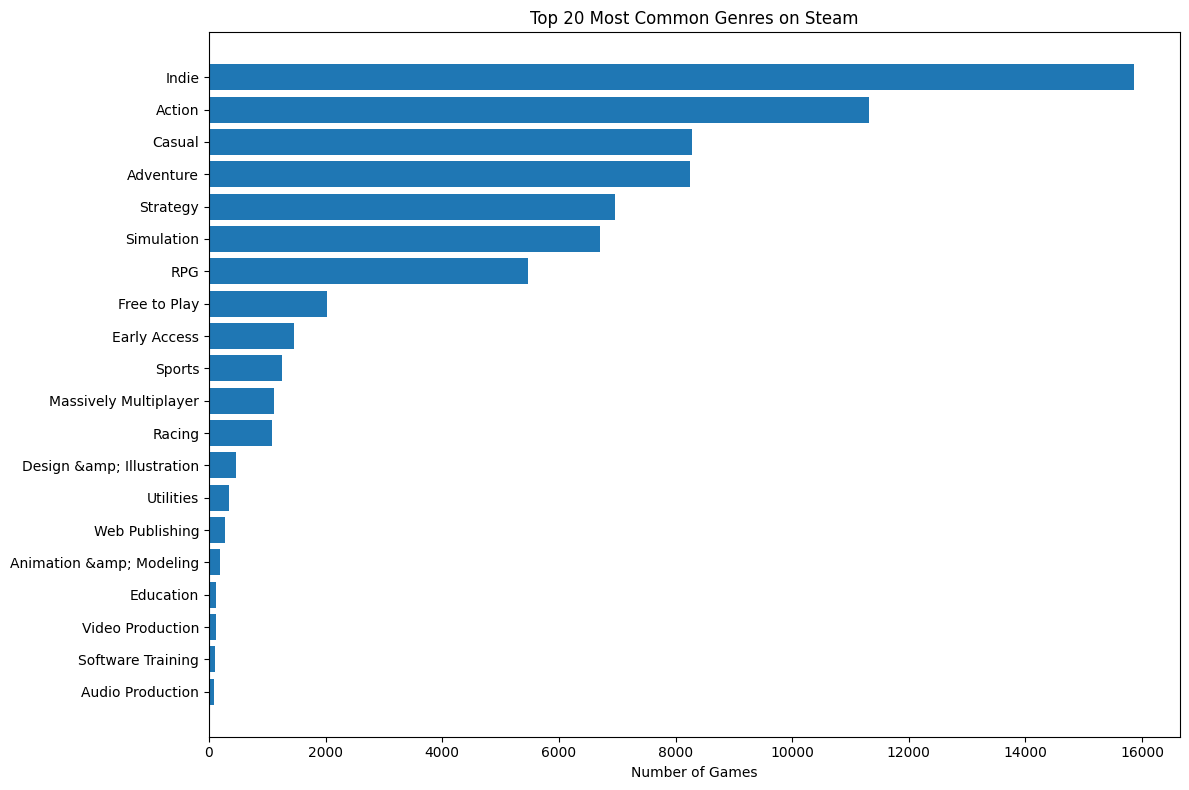

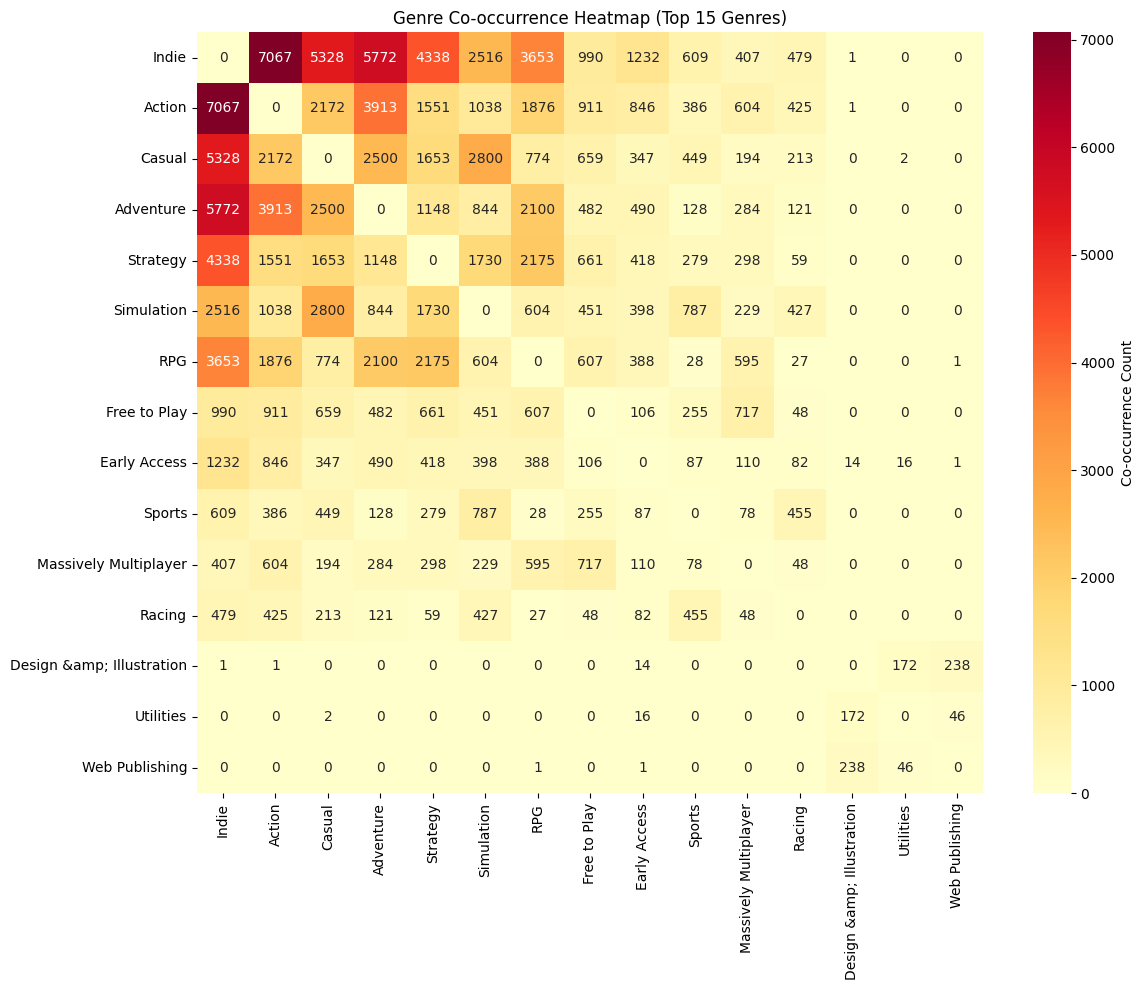

In [19]:
# Plot top genres
plt.figure(figsize=(12, 8))
top_20_genres = genre_counts.most_common(20)
genres, counts = zip(*top_20_genres)
plt.barh(genres, counts)
plt.xlabel('Number of Games')
plt.title('Top 20 Most Common Genres on Steam')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Heatmap of genre co-occurrence
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Co-occurrence Count'})
plt.title('Genre Co-occurrence Heatmap (Top 15 Genres)')
plt.tight_layout()
plt.show()

Graphs and analysis of the australian_user_items dataset, particularly for the item count, total playtime, and average playtime per game of each user, along with raw playtimes per game. We see that for all of these, there are massive outliers (some people play just 1 game for over 500,000+ hours, some people have thousands of games in their library, etc), and graphs are skewed extremely heavily to the right.

In [20]:
def parse_items(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

aus_item_df["parsed_items"] = aus_item_df["items"].apply(parse_items)

# extract playtime stats for each user
def compute_user_playtimes(items_list):
    playtimes = [item.get("playtime_forever", 0) for item in items_list]
    return pd.Series({
        "total_playtime": sum(playtimes),
        "avg_playtime": sum(playtimes) / len(playtimes) if len(playtimes) > 0 else 0,
        "max_playtime": max(playtimes) if len(playtimes) > 0 else 0,
        "min_playtime": min(playtimes) if len(playtimes) > 0 else 0,
        "num_games": len(playtimes)
    })

playtime_stats = aus_item_df["parsed_items"].apply(compute_user_playtimes)

# merge back into dataframe
aus_item_df = pd.concat([aus_item_df, playtime_stats], axis=1)

In [21]:
# print summary statistics 
print("==== ITEMS COUNT SUMMARY ====")
print(aus_item_df["items_count"].describe(), end="\n\n")

print("==== TOTAL PLAYTIME SUMMARY ====")
print(aus_item_df["total_playtime"].describe(), end="\n\n")

print("==== AVERAGE PLAYTIME PER GAME SUMMARY ====")
print(aus_item_df["avg_playtime"].describe(), end="\n\n")

print("==== PER-GAME PLAYTIME DISTRIBUTION ====")

# flatten all per-game playtimes into a single list
all_playtimes = [
    item.get("playtime_forever", 0)
    for items in aus_item_df["parsed_items"]
    for item in items
]

all_playtimes = pd.Series(all_playtimes)
print(all_playtimes.describe(), end="\n\n")

==== ITEMS COUNT SUMMARY ====
count    88310.000000
mean        58.353629
std        122.312095
min          0.000000
25%          3.000000
50%         26.000000
75%         73.000000
max       7762.000000
Name: items_count, dtype: float64

==== TOTAL PLAYTIME SUMMARY ====
count    8.831000e+04
mean     5.785734e+04
std      8.452178e+04
min      0.000000e+00
25%      4.320000e+02
50%      2.692150e+04
75%      8.441725e+04
max      4.660393e+06
Name: total_playtime, dtype: float64

==== AVERAGE PLAYTIME PER GAME SUMMARY ====
count     88310.000000
mean       1213.714219
std        2603.646602
min           0.000000
25%          77.435065
50%         644.941264
75%        1463.276215
max      216412.000000
Name: avg_playtime, dtype: float64

==== PER-GAME PLAYTIME DISTRIBUTION ====
count    5.153209e+06
mean     9.914951e+02
std      5.418204e+03
min      0.000000e+00
25%      0.000000e+00
50%      3.400000e+01
75%      3.550000e+02
max      6.427730e+05
dtype: float64



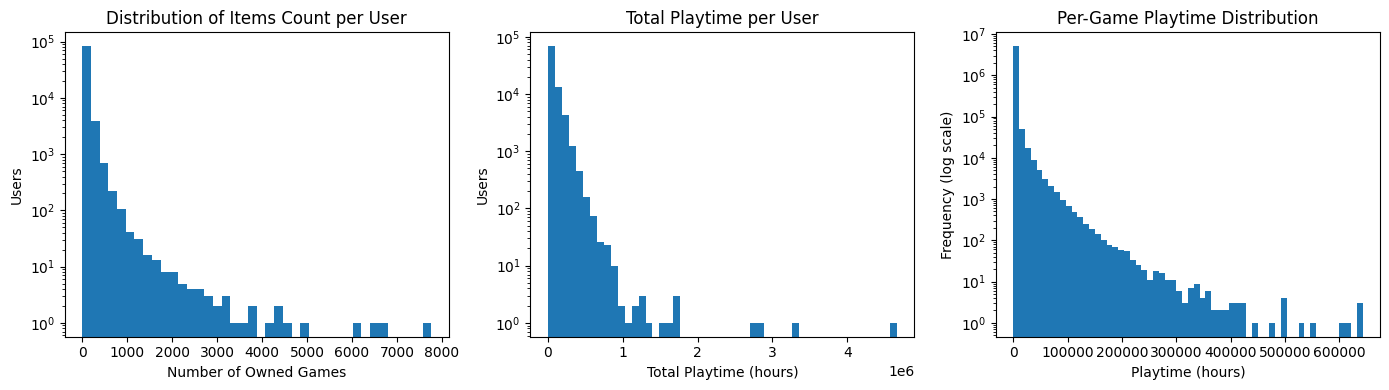

In [22]:
# plot histograms
plt.figure(figsize=(14, 4))

# histogram 1: items_count
plt.subplot(1, 3, 1)
plt.hist(aus_item_df["items_count"], bins=40)
plt.yscale("log")
plt.title("Distribution of Items Count per User")
plt.xlabel("Number of Owned Games")
plt.ylabel("Users")

# histogram 2: total playtime per user
plt.subplot(1, 3, 2)
plt.hist(aus_item_df["total_playtime"], bins=50)
plt.yscale("log")
plt.title("Total Playtime per User")
plt.xlabel("Total Playtime (hours)")
plt.ylabel("Users")

# histogram 3: per-game playtime
plt.subplot(1, 3, 3)
plt.hist(all_playtimes, bins=60)
plt.yscale("log")     
plt.title("Per-Game Playtime Distribution")
plt.xlabel("Playtime (hours)")
plt.ylabel("Frequency (log scale)")

plt.tight_layout()
plt.show()

EDA of reviews, along with plotting a user's playtime for a game vs whether or not it was recommended by said user. We see that there may be a correlation between playtime and recommend (the graph shows how games with longer playtimes by a user tend to then be recommended by the user).

In [23]:
def parse_reviews(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

aus_review_df["parsed_reviews"] = aus_review_df["reviews"].apply(parse_reviews)

# extract review statistics for each user
def compute_review_stats(review_list):
    if not review_list:
        return pd.Series({
            "num_reviews": 0,
            "avg_review_length": 0,
            "num_recommended": 0,
            "num_not_recommended": 0
        })
    
    lengths = [len(r.get("review", "")) for r in review_list]
    recommends = [r.get("recommend", False) for r in review_list]

    return pd.Series({
        "num_reviews": len(review_list),
        "avg_review_length": sum(lengths) / len(lengths),
        "num_recommended": sum(recommends),
        "num_not_recommended": len(recommends) - sum(recommends)
    })

review_stats = aus_review_df["parsed_reviews"].apply(compute_review_stats)
aus_review_df = pd.concat([aus_review_df, review_stats], axis=1)

In [24]:
# global summary statistics
print("\n===== REVIEW SUMMARY STATISTICS =====")
print(aus_review_df["num_reviews"].describe())
print("\nAverage reviews per user:", aus_review_df["num_reviews"].mean())
print("\n===== REVIEW LENGTH SUMMARY =====")
print(aus_review_df["avg_review_length"].describe())


===== REVIEW SUMMARY STATISTICS =====
count    25799.000000
mean         2.298733
std          2.005754
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
Name: num_reviews, dtype: float64

Average reviews per user: 2.2987325090119772

===== REVIEW LENGTH SUMMARY =====
count    25799.000000
mean       187.215560
std        350.597778
min          0.000000
25%         32.000000
50%         80.600000
75%        196.773810
max       7999.000000
Name: avg_review_length, dtype: float64


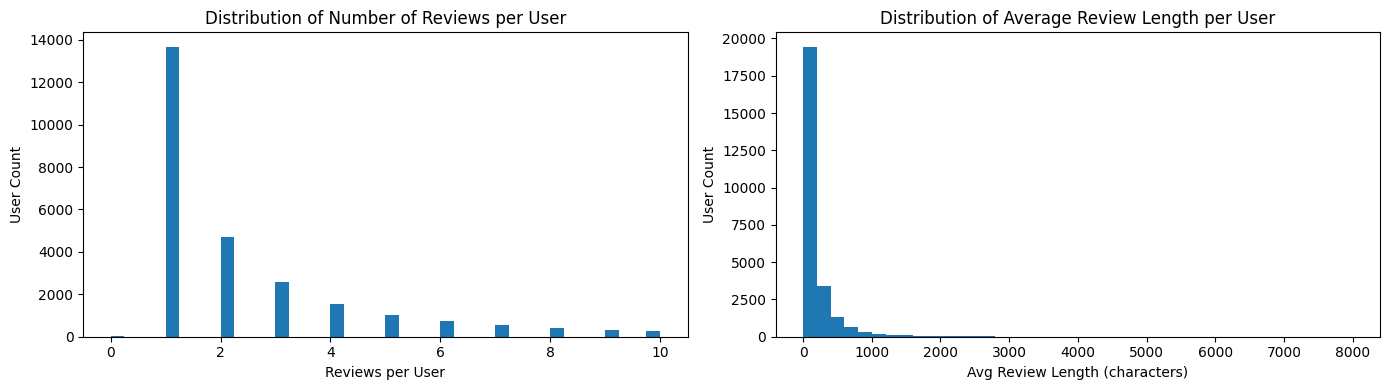

In [25]:
# histograms
plt.figure(figsize=(14, 4))

# reviews per user
plt.subplot(1, 2, 1)
plt.hist(aus_review_df["num_reviews"], bins=40)
plt.title("Distribution of Number of Reviews per User")
plt.xlabel("Reviews per User")
plt.ylabel("User Count")

# beview lengths
plt.subplot(1, 2, 2)
plt.hist(aus_review_df["avg_review_length"], bins=40)
plt.title("Distribution of Average Review Length per User")
plt.xlabel("Avg Review Length (characters)")
plt.ylabel("User Count")

plt.tight_layout()
plt.show()

In [26]:
# review recommend - playtime correlation for same game
# ensure items are parsed
def parse_items(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

aus_item_df["parsed_items"] = aus_item_df["items"].apply(parse_items)

# expand items into rows
item_rows = []
for idx, row in aus_item_df.iterrows():
    for it in row["parsed_items"]:
        item_rows.append({
            "user_id": row["user_id"],
            "item_id": str(it.get("item_id")),
            "playtime_forever": it.get("playtime_forever", 0)
        })

items_expanded_df = pd.DataFrame(item_rows)

# expand reviews into rows
review_rows = []
for idx, row in aus_review_df.iterrows():
    for rv in row["parsed_reviews"]:
        review_rows.append({
            "user_id": row["user_id"],
            "item_id": str(rv.get("item_id")),
            "recommend": rv.get("recommend"),
            "review_length": len(rv.get("review", "")),
        })

reviews_expanded_df = pd.DataFrame(review_rows)

# merge to align reviews with playtime per user-game
merged_user_game = reviews_expanded_df.merge(
    items_expanded_df,
    on=["user_id", "item_id"],
    how="inner"  # only include users in both datasets
)

In [27]:
print("\n===== MERGED USER-GAME REVIEW/PLAYTIME DATA =====")
print(merged_user_game.head())


===== MERGED USER-GAME REVIEW/PLAYTIME DATA =====
             user_id item_id  recommend  review_length  playtime_forever
0  76561197970982479    1250       True            249             10006
1  76561197970982479   22200       True             36               271
2  76561197970982479   43110       True            182               834
3            js41637  251610       True            566                84
4            js41637  227300       True            590               551



Correlation between playtime and recommendation:
                  playtime_forever  recommend
playtime_forever          1.000000   0.055012
recommend                 0.055012   1.000000


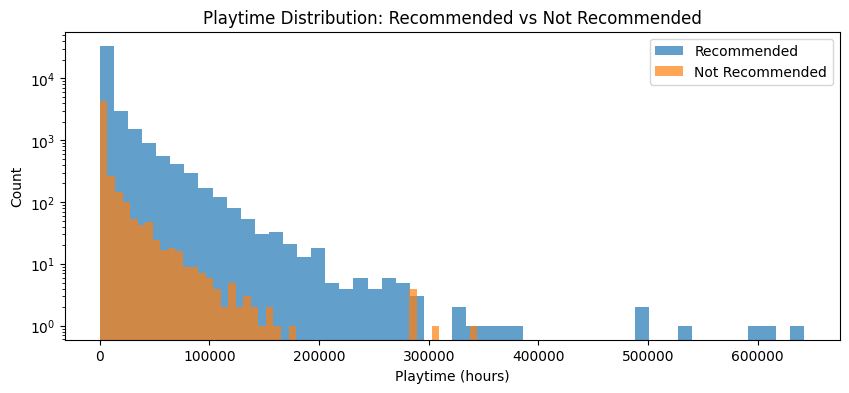

In [28]:
# correlation Analysis
if not merged_user_game.empty:
    print("\nCorrelation between playtime and recommendation:")
    print(merged_user_game[["playtime_forever", "recommend"]].corr())

    # histogram: playtime by recommendation
    plt.figure(figsize=(10, 4))
    plt.hist(merged_user_game[merged_user_game["recommend"] == True]["playtime_forever"],
             bins=50, alpha=0.7, label="Recommended")
    plt.hist(merged_user_game[merged_user_game["recommend"] == False]["playtime_forever"],
             bins=50, alpha=0.7, label="Not Recommended")
    plt.legend()
    plt.xlabel("Playtime (hours)")
    plt.ylabel("Count")
    plt.title("Playtime Distribution: Recommended vs Not Recommended")
    plt.yscale("log")
    plt.show()
else:
    print("\nNo overlapping users/games to compute correlation.")

# Base Model

## Import Data

In [2]:
print("Loading data")
data = []
with gzip.open('australian_users_items.json.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        data.append(ast.literal_eval(line))

interactions = []
for user in data:
    uid = user['user_id']
    u_items = user['items_count']
    for item in user['items']:
        interactions.append({
            'user_id': uid,
            'item_id': item['item_id'],
            'playtime_forever': item['playtime_forever'],
            'user_items_count': u_items
        })

df = pd.DataFrame(interactions)
df_positive = df[df['playtime_forever'] > 0].copy()
df_positive['target'] = 1

Loading data


## Feature Engineering

In [3]:
# Neg sampling
print("Generating neg samples")

top_games = df_positive['item_id'].value_counts().head(500).index.tolist()

played_pairs = set(zip(df_positive['user_id'], df_positive['item_id']))
users = df_positive['user_id'].values
n_samples = len(users)

negative_items = np.empty(n_samples, dtype=object)
filled_mask = np.zeros(n_samples, dtype=bool)
retry_count = 0

Generating neg samples


In [4]:
while not filled_mask.all() and retry_count < 100:
    missing = (~filled_mask).sum()
    # Sample only from Top 500 games
    candidates = np.random.choice(top_games, size=missing)
    current_users = users[~filled_mask]
    
    valid_mask = np.array([(u, i) not in played_pairs for u, i in zip(current_users, candidates)])
    
    if valid_mask.any():
        idx = np.where(~filled_mask)[0][valid_mask]
        negative_items[idx] = candidates[valid_mask]
        filled_mask[idx] = True
    retry_count += 1
    if retry_count % 10 == 0:
        print(f"Pass {retry_count}: {filled_mask.sum()}/{n_samples}")

Pass 10: 3284948/3285246
Pass 20: 3285236/3285246
Pass 30: 3285245/3285246


In [5]:
df_negative = pd.DataFrame({
    'user_id': users,
    'item_id': negative_items,
    'user_items_count': df_positive['user_items_count'].values,
    'target': 0
})

In [6]:
# Combine
df_model = pd.concat([df_positive[['user_id', 'item_id', 'user_items_count', 'target']], 
                      df_negative[['user_id', 'item_id', 'user_items_count', 'target']]], ignore_index=True)
df_model = df_model.dropna().sample(frac=1, random_state=42).reset_index(drop=True)

## Model Training

In [7]:
# Train/Test Split
train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42)

# Feature Engineering
print("Calculating features")
train_pos = train_df[train_df['target'] == 1]
pop_map = train_pos.groupby('item_id')['user_id'].nunique().reset_index()
pop_map.columns = ['item_id', 'item_popularity']

train_df = train_df.merge(pop_map, on='item_id', how='left').fillna(0)
test_df = test_df.merge(pop_map, on='item_id', how='left').fillna(0)

Calculating features


In [8]:
features = ['user_items_count', 'item_popularity']
X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
print("Training Model")
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

Training Model


LogisticRegression()

In [10]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

print(f"ROC AUC: {auc:.4f}")
print(f"PR AUC:  {pr_auc:.4f}")

ROC AUC: 0.5219
PR AUC:  0.6217


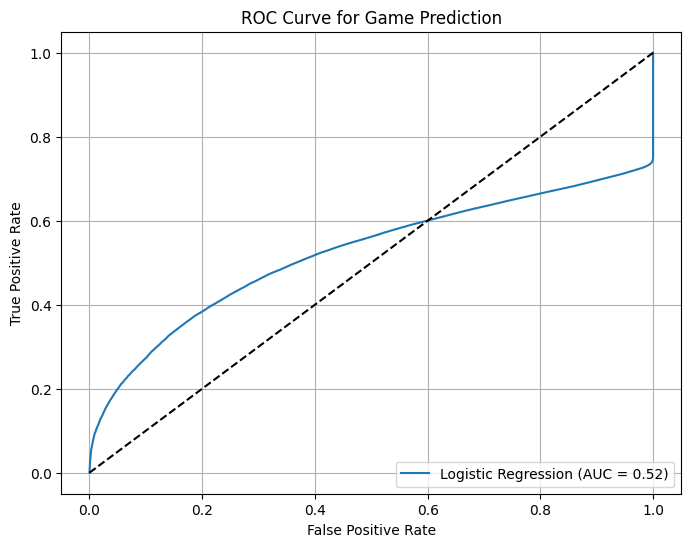

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# plotting

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Game Prediction')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve_base.png')

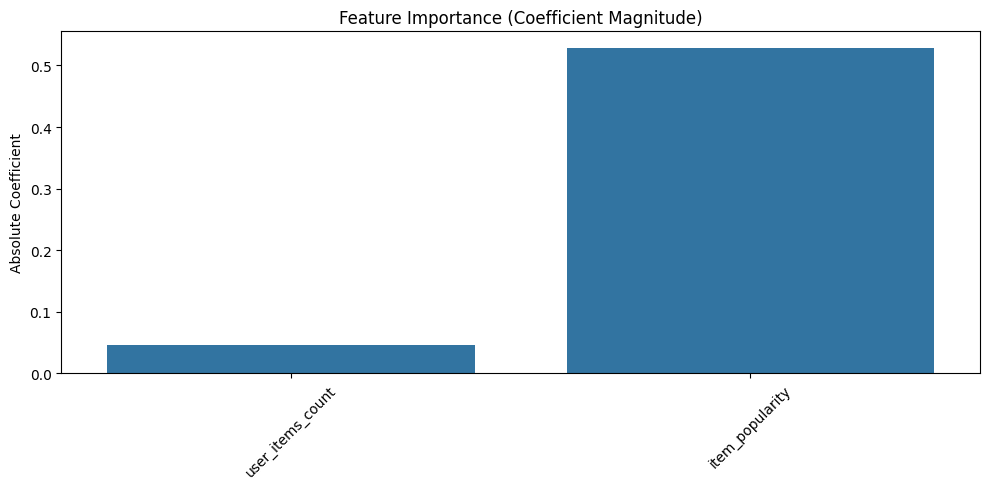

In [12]:
plt.figure(figsize=(10, 5))
sns.barplot(x=features, y=np.abs(model.coef_[0]))
plt.title('Feature Importance (Coefficient Magnitude)')
plt.ylabel('Absolute Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_importance_base.png')

# Improved Model

In [13]:
MAX_TEXT_FEATURES = 500
MAX_TAG_FEATURES = 100
EMBEDDING_DIM = 32
BATCH_SIZE = 256
EPOCHS = 5

def smart_open(file_path, mode='rt', encoding='utf-8'):
    if os.path.exists(file_path):
        if file_path.endswith('.gz'):
            return gzip.open(file_path, mode=mode, encoding=encoding)
        return open(file_path, mode=mode, encoding=encoding)
    
    gz_path = file_path + '.gz'
    if os.path.exists(gz_path):
        return gzip.open(gz_path, mode=mode, encoding=encoding)
    return open(file_path, mode=mode, encoding=encoding)

def clean_text(text):
    if not text: return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

## Import Data

In [14]:
# Load User/Item Interactions
print("Loading interactions")
user_data = []
with smart_open('australian_users_items.json.gz') as f:
    for line in f:
        user_data.append(ast.literal_eval(line))

Loading interactions


In [15]:
# Load Game Metadata
print("Loading game metadata")
games_dict = {}
with smart_open('steam_games.json.gz') as f:
    for line in f:
        try:
            game = ast.literal_eval(line)
            gid = None
            if 'id' in game: gid = str(game['id'])
            elif 'app_id' in game: gid = str(game['app_id'])
            if not gid: continue
            
            # Extract Price
            price = game.get('price', 0)
            if isinstance(price, str):
                price = 0 if 'free' in price.lower() else float(price) if price.replace('.', '', 1).isdigit() else 0
            
            # Extract Tags
            tags = game.get('tags', []) + game.get('genres', [])
            tags_str = " ".join([t.lower() for t in tags])
            
            games_dict[gid] = {'price': price, 'tags': tags_str}
        except:
            continue

Loading game metadata


In [16]:
# Load Reviews
print("Loading reviews")
user_reviews_text = defaultdict(list)
with smart_open('steam_reviews.json.gz') as f:
    for line in f:
        try:
            node = ast.literal_eval(line)
            # Resolve ID
            uid = str(node.get('user_id', node.get('username', '')))
            if not uid: continue
            
            text = node.get('text', '')
            if text:
                user_reviews_text[uid].append(clean_text(text))
        except:
            continue

# Collapse reviews into single string per user
user_reviews_map = {uid: " ".join(texts) for uid, texts in user_reviews_text.items()}
del user_reviews_text
gc.collect()

Loading reviews


19272

In [17]:
print("df creation")

interactions = []
for user in user_data:
    uid = str(user['user_id'])
    for item in user['items']:
        interactions.append({
            'user_id': uid,
            'item_id': str(item['item_id']),
            'playtime': item['playtime_forever']
        })

df = pd.DataFrame(interactions)
del user_data, interactions
gc.collect()

# Filter only played games and existing games
df = df[df['playtime'] > 0]
df = df[df['item_id'].isin(games_dict.keys())]

df creation


## Feature Engineering

In [18]:
# Calculate popularity
pop_counts = df['item_id'].value_counts().to_dict()
df['popularity'] = df['item_id'].map(pop_counts)

In [19]:
# Negative sampling
print("Creating negative samples")
# Get list of all users and top 500 popular items
all_users = df['user_id'].unique()
top_items = list(df['item_id'].value_counts().head(500).index)

Creating negative samples


In [20]:
# Create a set of existing pairs for fast lookup
existing_pairs = set(zip(df['user_id'], df['item_id']))

n_positives = len(df)
target_negatives = n_positives

unique_users = df['user_id'].unique()
top_items_array = np.array(top_items)
existing_pairs = set(zip(df['user_id'], df['item_id']))

In [21]:
negative_rows = []

# Generate batches until we hit the target
while len(negative_rows) < target_negatives:
    needed = target_negatives - len(negative_rows)
    
    batch_size = int(needed * 1.2)
    
    batch_u = np.random.choice(unique_users, size=batch_size)
    batch_i = np.random.choice(top_items_array, size=batch_size)
    
    # Filter valid negatives
    for u, i in zip(batch_u, batch_i):
        if len(negative_rows) >= target_negatives:
            break
            
        if (u, i) not in existing_pairs:
            negative_rows.append({
                'user_id': u,
                'item_id': i,
                'playtime': 0,
                'popularity': pop_counts.get(i, 0)
            })
            # Add to existing_pairs to ensure we don't accidentally add the same negative twice
            existing_pairs.add((u, i))

df_neg = pd.DataFrame(negative_rows)
df_neg['target'] = 0
df['target'] = 1

In [22]:
# Merge Positive and Negative
full_df = pd.concat([df[['user_id', 'item_id', 'popularity', 'target']], 
                     df_neg[['user_id', 'item_id', 'popularity', 'target']]], ignore_index=True)

# Shuffle
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Dataset Size: {len(full_df)} interactions")

Dataset Size: 5736110 interactions


In [23]:
print("Features")

# ID Encoding (Label Encoding)
print("Encoding IDs")
user_encoder = LabelEncoder()
full_df['user_idx'] = user_encoder.fit_transform(full_df['user_id'])
n_users = len(user_encoder.classes_)

item_encoder = LabelEncoder()
full_df['item_idx'] = item_encoder.fit_transform(full_df['item_id'])
n_items = len(item_encoder.classes_)

Features
Encoding IDs


In [24]:
# TF-IDF on User Reviews
print("Vectorizing reviews")
reviews_series = full_df['user_id'].map(lambda u: user_reviews_map.get(u, ""))
tfidf_rev = TfidfVectorizer(max_features=MAX_TEXT_FEATURES, stop_words='english', dtype=np.float32)
X_reviews = tfidf_rev.fit_transform(reviews_series).toarray().astype(np.float32)

# TF-IDF on Game Tags
print("Vectorizing game tags")
tags_series = full_df['item_id'].map(lambda i: games_dict.get(i, {}).get('tags', ""))
tfidf_tags = TfidfVectorizer(max_features=MAX_TAG_FEATURES, stop_words='english', dtype=np.float32)
X_tags = tfidf_tags.fit_transform(tags_series).toarray().astype(np.float32)

Vectorizing reviews
Vectorizing game tags


In [25]:
# Numerical Features (Price & Popularity)
print("Normalizing Numerical Features")
price_series = full_df['item_id'].map(lambda i: games_dict.get(i, {}).get('price', 0)).values.reshape(-1, 1)
pop_series = full_df['popularity'].values.reshape(-1, 1)

scaler = StandardScaler()
X_nums = scaler.fit_transform(np.hstack([price_series, pop_series])).astype(np.float32)

X_side = np.hstack([X_reviews, X_tags, X_nums])

print(f"Final Side Feature Dimension: {X_side.shape[1]}")

Normalizing Numerical Features
Final Side Feature Dimension: 602


## Model Training

In [26]:
# Clean up memory
del reviews_series, tags_series, X_reviews, X_tags, X_nums
gc.collect()

# Prepare inputs
X_u = full_df['user_idx'].values
X_i = full_df['item_idx'].values
y = full_df['target'].values

# Train/Test split
X_u_train, X_u_test, X_i_train, X_i_test, X_s_train, X_s_test, y_train, y_test = train_test_split(
    X_u, X_i, X_side, y, test_size=0.2, random_state=42
)

In [27]:
print("Generating model")

# Define inputs
user_input = layers.Input(shape=(1,), name='user_input')
item_input = layers.Input(shape=(1,), name='item_input')
side_input = layers.Input(shape=(X_side.shape[1],), name='side_input')

del X_side, X_u, X_i, y
del full_df
gc.collect()

Generating model


0

In [28]:
# Latent factor embeddings
u_emb = layers.Embedding(n_users, EMBEDDING_DIM, embeddings_regularizer=regularizers.l2(1e-5))(user_input)
i_emb = layers.Embedding(n_items, EMBEDDING_DIM, embeddings_regularizer=regularizers.l2(1e-5))(item_input)

u_vec = layers.Flatten()(u_emb)
i_vec = layers.Flatten()(i_emb)

mf_layer = layers.Dot(axes=1)([u_vec, i_vec])

dense_1 = layers.Dense(256, activation='relu')(side_input)
dense_1 = layers.Dropout(0.4)(dense_1)
dense_2 = layers.Dense(128, activation='relu')(dense_1)

In [29]:
# Include the raw user/item vectors in the deep path too, to learn non-linear interactions
concat = layers.Concatenate()([mf_layer, u_vec, i_vec, dense_2])

# Final prediction layer
pred_layer = layers.Dense(64, activation='relu')(concat)
output = layers.Dense(1, activation='sigmoid')(pred_layer)

In [30]:
model = Model(inputs=[user_input, item_input, side_input], outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision')]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ side_input          │ (None, 602)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │  2,172,608 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │    272,736 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    154,368 │ side_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 193)       │          0 │ dot[0][0],        │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     12,416 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,645,089 (10.09 MB)

 Trainable params: 2,645,089 (10.09 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
print("Training")

history = model.fit(
    [X_u_train, X_i_train, X_s_train],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_u_test, X_i_test, X_s_test], y_test),
    verbose=1
)

print("Finished training")

Training
Epoch 1/5


2025-11-29 15:50:40.332733: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 11050042304 exceeds 10% of free system memory.


17926/17926 ━━━━━━━━━━━━━━━━━━━━ 292s 16ms/step - auc: 0.8644 - loss: 0.4668 - precision: 0.8001 - val_auc: 0.8995 - val_loss: 0.4287 - val_precision: 0.8247
Epoch 2/5
17926/17926 ━━━━━━━━━━━━━━━━━━━━ 288s 16ms/step - auc: 0.9111 - loss: 0.4178 - precision: 0.8338 - val_auc: 0.9143 - val_loss: 0.4231 - val_precision: 0.8373
Epoch 3/5
17926/17926 ━━━━━━━━━━━━━━━━━━━━ 284s 16ms/step - auc: 0.9300 - loss: 0.3985 - precision: 0.8553 - val_auc: 0.9171 - val_loss: 0.4270 - val_precision: 0.8343
Epoch 4/5
17926/17926 ━━━━━━━━━━━━━━━━━━━━ 283s 16ms/step - auc: 0.9373 - loss: 0.3890 - precision: 0.8647 - val_auc: 0.9179 - val_loss: 0.4290 - val_precision: 0.8428
Epoch 5/5
17926/17926 ━━━━━━━━━━━━━━━━━━━━ 283s 16ms/step - auc: 0.9399 - loss: 0.3849 - precision: 0.8685 - val_auc: 0.9180 - val_loss: 0.4300 - val_precision: 0.8454
Finished training


In [32]:
preds = model.predict([X_u_test, X_i_test, X_s_test], batch_size=BATCH_SIZE)
roc = roc_auc_score(y_test, preds)
pr = average_precision_score(y_test, preds)

print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC:  {pr:.4f}")

4482/4482 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
ROC AUC: 0.9180
PR AUC:  0.9250


In [33]:
# Example Predictions
print("\nSample Predictions:")
for i in range(5):
    p = preds[i][0]
    actual = y_test[i]
    print(f"Predicted: {p:.4f} | Actual: {actual}")


Sample Predictions:
Predicted: 0.6199 | Actual: 0
Predicted: 0.0625 | Actual: 0
Predicted: 0.9535 | Actual: 1
Predicted: 0.7951 | Actual: 1
Predicted: 0.8379 | Actual: 1
